In [260]:
#mały i zbalansowany zbiór - 30 wierszy z każdego typu
#podział danych w relacji 25/5 (można powiedzieć, że stratified, zbiór testowy ~20%)
#nie usuwamy rzędów zawierających mniej niż 50 postów
#nie rozdzielamy wierszy na posty, a zcalamy posty w jeden długi tekst w wierszu

# Praca magisterska

### Tworzenie środowiska

Tworzenie środowiska *mgr* korzystając z instrukcji https://www.tensorflow.org/install/pip?hl=pl#windows-native .

In [261]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Import bibliotek

In [262]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
#from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Zbiór danych

Pochodzi z platformy Kaggle: https://www.kaggle.com/datasets/datasnaek/mbti-type .

In [263]:
#każdy rząd składa się z typu osobowości i 50 ostatnich postów
df = pd.read_csv('mbti_1.csv', sep=',')
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [264]:
df.shape

(8675, 2)

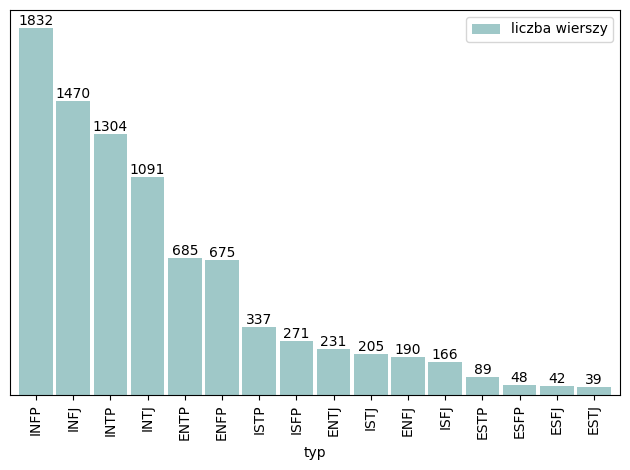

In [265]:
#podstawowy zbiór danych - dystrybucja postów między typami
#https://www.simplifiedsciencepublishing.com/resources/best-color-palettes-for-scientific-figures-and-data-visualizations

ax = df.groupby('type').count().sort_values(by='posts', ascending=False).plot.bar(width=0.9, color='#9fc8c8')
ax.bar_label(ax.containers[0])[1]
ax.legend(["liczba wierszy"])
ax.set_xlabel("typ")
ax.yaxis.set_visible(False)
ax.figure.tight_layout()
ax.figure.savefig('distribution.png')

### Mały i zbalansowany zbiór

Rozpoczniemy od stworzenia małego zbalansowanego zbioru danych (używając zbioru podstawowego). W tym celu wylosujemy identyczną ilość próbek z każdej z 16 klas.

In [266]:
#16 typów osobowości - nazwy klas
types = df.type.unique().tolist()
print(types)

#dodanie kolumny z klasami wyrażonymi liczbami (0 - 15)
df['class_no'] = df.apply(lambda x: types.index(x['type']), axis=1)

df

['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP', 'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']


,type,posts,class_no
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,0
1,ENTP,'I'm finding the lack of me in these posts ver...,1
2,INTP,'Good one _____ https://www.youtube.com/wat...,2
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",3
4,ENTJ,'You're fired.|||That's another silly misconce...,4
...,...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...,8
8671,ENFP,'So...if this thread already exists someplace ...,7
8672,INTP,'So many questions when i do these things. I ...,2
8673,INFP,'I am very conflicted right now when it comes ...,6


In [267]:
idx_to_type = {}

for i, t in enumerate(types):
    idx_to_type[i] = t

idx_to_type

{0: 'INFJ',
 1: 'ENTP',
 2: 'INTP',
 3: 'INTJ',
 4: 'ENTJ',
 5: 'ENFJ',
 6: 'INFP',
 7: 'ENFP',
 8: 'ISFP',
 9: 'ISTP',
 10: 'ISFJ',
 11: 'ISTJ',
 12: 'ESTP',
 13: 'ESFP',
 14: 'ESTJ',
 15: 'ESFJ'}

Pozostawienie zbiorów postów w całości (zcalenie)

In [268]:
#zamiana separatora postów na inny, łatwo rozróżnialny
df['posts_merged'] = df['posts'].str.replace(pat = '|||', repl = ' ')

# #zamiana stringów na listy postów
# df['posts_list'] = df['posts_list'].str.split(pat = ' ||| ', regex=False)


In [269]:
# #dodanie kolumny z długościami list
# df['len_posts'] = df['posts_list'].str.len()

In [270]:
# #niektóre rzędy posiadają mniej niż 50 postów
# df[df.len_posts < 50].shape

In [271]:
# #usuwamy rzędy zawierające mniej niż 50 postów
# df = df[df.len_posts == 50]

# #usuwanie kolumny z ilościami postów
# df = df.drop(columns = ['len_posts'])

In [272]:
df[['type', 'posts']].groupby('type').count().sort_values(by='posts', ascending=False)#.plot.bar(width=0.9)
# ax.bar_label(ax.containers[0])[1]
# ax.yaxis.set_visible(False)

,posts
type,
INFP,1832
INFJ,1470
INTP,1304
INTJ,1091
ENTP,685
ENFP,675
ISTP,337
ISFP,271
ENTJ,231


In [273]:
#najmniej postów jest dostępnych dla typu ESTJ (35)
#wybierzmy po 30 próbek z każdego typu (maksymalnie po 1500 postów)

random.seed(123)

df_equal = pd.DataFrame()
for t in types:
    df_type = df[df.type == t]
    df_type = df_type.loc[random.sample(df_type.index.to_list(), 30)]
    print(df_type.index)  #zawsze te same indeksy z powodu seeda
    df_equal = pd.concat([df_equal, df_type])
df_equal.shape #16 * 30

Index([ 653, 3225, 1126, 4817, 3208, 1370,  480, 4457, 6491, 6806, 3942, 4063,
        629, 2061, 1709, 3990, 6791, 3958, 8409, 2972, 2095,   10, 5104, 1129,
       7224, 4445,  862,   60, 3716, 5251],
      dtype='int64')
Index([1309,  639, 1217, 8665, 1824, 1621,  314, 3620, 5406, 7356, 5906, 3103,
       5818,  552, 3758, 4226, 6601, 6011, 2417, 7817, 8320, 6644, 7202, 3854,
        163, 5043, 8405, 6450, 5435, 6784],
      dtype='int64')
Index([8159, 6714, 7200, 5806, 5175, 7058,  358, 2554, 1171, 6717, 3682, 2370,
       4617, 4636, 7646, 5454,  977, 6331, 5363, 7873, 4626,  178, 2656, 8029,
       1291, 8571, 4992,  157, 4782, 3228],
      dtype='int64')
Index([6521, 8666, 8131,  931, 4818, 8047, 3772, 7840, 2818, 2441, 7188, 6159,
       7501,  704,  186, 2099, 7442, 3104,  339, 4225, 5758, 4582, 6977, 6770,
          3, 1754,  979, 8264, 5780, 1506],
      dtype='int64')
Index([ 819, 4573,   24, 7824, 5458, 4075,  737, 5599, 6955, 6275, 4306,  240,
       3647, 3090, 4982,  284

(480, 4)

### Podział danych

Ważne, aby posty jednej osoby nie znalazły się zarówno w zbiorze testowym jak i treningowym. Wybrana relacja train/test: 25/5.

In [274]:
random.seed(10)

df_test = pd.DataFrame()
df_train = pd.DataFrame()

for t in types:
    df_type = df_equal[df_equal.type == t]

    test_indexes = random.sample(df_type.index.to_list(), 5)
    print(test_indexes)      #zawsze te same indeksy z powodu seeda
    df_type_test = df_type.loc[test_indexes]
    df_type_train = df_type[~df_type.index.isin(test_indexes)]

    df_test = pd.concat([df_test, df_type_test])
    df_train = pd.concat([df_train, df_type_train])

df_test.shape, df_train.shape

[8409, 3225, 2061, 3990, 653]
[314, 3758, 8405, 4226, 5406]
[4626, 8571, 7058, 6714, 977]
[2099, 7188, 8131, 7840, 6770]
[240, 4573, 3090, 7118, 5458]
[1334, 7545, 3217, 8247, 3264]
[3513, 3317, 2917, 5064, 6807]
[8013, 592, 1173, 3570, 2733]
[2829, 6481, 6699, 2169, 8273]
[3582, 2204, 4901, 2453, 3285]
[4498, 6144, 6933, 3648, 1814]
[1141, 2081, 7779, 7963, 7684]
[743, 4165, 8470, 3023, 5848]
[529, 617, 690, 2956, 6927]
[1112, 5264, 4148, 2344, 1916]
[3529, 1652, 627, 3026, 3495]


((80, 4), (400, 4))

In [275]:
df_test.index

Index([8409, 3225, 2061, 3990,  653,  314, 3758, 8405, 4226, 5406, 4626, 8571,
       7058, 6714,  977, 2099, 7188, 8131, 7840, 6770,  240, 4573, 3090, 7118,
       5458, 1334, 7545, 3217, 8247, 3264, 3513, 3317, 2917, 5064, 6807, 8013,
        592, 1173, 3570, 2733, 2829, 6481, 6699, 2169, 8273, 3582, 2204, 4901,
       2453, 3285, 4498, 6144, 6933, 3648, 1814, 1141, 2081, 7779, 7963, 7684,
        743, 4165, 8470, 3023, 5848,  529,  617,  690, 2956, 6927, 1112, 5264,
       4148, 2344, 1916, 3529, 1652,  627, 3026, 3495],
      dtype='int64')

### Rozpakowanie postów

Każda z 480 próbek zawiera wewnątrz maksymalnie 50 postów. Traktujemy je jako całość.

In [276]:
# #rozpakowanie list do osobnych rzędów
# df_test = df_test.explode('posts_list')
# df_train = df_train.explode('posts_list')

# df_test.shape, df_train.shape

In [277]:
df_test.head()

,type,posts,class_no,posts_merged
8409,INFJ,'Thought this lady standing beside me had huge...,0,'Thought this lady standing beside me had huge...
3225,INFJ,'I like how the time just flows by and and aft...,0,'I like how the time just flows by and and aft...
2061,INFJ,'Hmm.. I think I'm quite easy to become friend...,0,'Hmm.. I think I'm quite easy to become friend...
3990,INFJ,"'You see Ti in Miley? Hmmm, where do you see i...",0,"'You see Ti in Miley? Hmmm, where do you see i..."
653,INFJ,'I'm tired of the Christmas scene by the time ...,0,'I'm tired of the Christmas scene by the time ...


In [278]:
df_test.posts[3225], df_test.posts_merged[3225]

("'I like how the time just flows by and and after a couple of hours everything clean and neat .|||I was just wondering if I'm the only INFJ who isn't competitive. I really dislike competition, and I only compete with an xNFP and an annoying ESFJ, and I only compete with them about grades.   I...|||Waka waka is the name of the FIFA song... sorry for changing subject..  I don't know if Hitler could be and INFJ, but i think he could be. I think Hitler would be INFJ or INTJ ..   The Joker...|||yes.. very weird, but I enjoy it so I don't really see any point in stopping, nobody get's hurt or mad. Mostly :laughing:|||AHH! FIFA song! yaaa ... it's so good, a shame Shakira is in it.. i don't really like her. GOD i love football, the european :)   oh and I speak well in front of a crowd i f I know what I'm talking...|||I hide things....  I hide my own things, hide other's things.  I like borrowing other's things too, use them all day and give them back.  Mostly I borrow without asking. And I l

In [279]:
#usunięcie zbiorczej kolumny
df_test = df_test.drop(columns = ['posts'])
df_train = df_train.drop(columns = ['posts'])

# #zmiana nazwy kolumny
# df_test = df_test.rename(columns = {'posts_list':'post'})
# df_train = df_train.rename(columns = {'posts_list':'post'})

In [280]:
df_test.dtypes

type            object
class_no         int64
posts_merged    object
dtype: object

In [281]:
#zmiana typów zmiennych
df_test = df_test.astype({'type':'string', 'posts_merged':'string'})
df_train = df_train.astype({'type':'string', 'posts_merged':'string'})

In [282]:
df_test.shape, df_train.shape   # 5 rzędów * 16 osobowości * 50 postów, 25 rzędów * 16 osobowości * 50 postów

((80, 3), (400, 3))

In [283]:
df_test.head()

,type,class_no,posts_merged
8409,INFJ,0,'Thought this lady standing beside me had huge...
3225,INFJ,0,'I like how the time just flows by and and aft...
2061,INFJ,0,'Hmm.. I think I'm quite easy to become friend...
3990,INFJ,0,"'You see Ti in Miley? Hmmm, where do you see i..."
653,INFJ,0,'I'm tired of the Christmas scene by the time ...


### Czyszczenie tekstu i ekstrakcja cech

Tokenizacja

In [284]:
#zmiejszenie liter i rozdzielenie ciągów znaków na listy słów/cząstek
# df_test['post_words'] = df_test.apply(lambda x: word_tokenize(x['post'].lower()), axis=1)
# df_train['post_words'] = df_train.apply(lambda x: word_tokenize(x['post'].lower()), axis=1)

#zmiejszenie liter i rozdzielenie ciągów znaków na listy słów/cząstek - ten tokenizer nie rozdziela na "he" + "'s" i zachowuje całe emotki oraz hashtagi
tweet_tokenizer = TweetTokenizer()
df_test['post_words'] = df_test.apply(lambda x: tweet_tokenizer.tokenize(x['posts_merged'].lower()), axis=1)
df_train['post_words'] = df_train.apply(lambda x: tweet_tokenizer.tokenize(x['posts_merged'].lower()), axis=1)

In [285]:
print(df_test.index) #problem powtarzalnych indeksów

#naprawa - unikalne indeksy
df_test = df_test.reset_index()
df_train = df_train.reset_index()

print(df_test.index)

Index([8409, 3225, 2061, 3990,  653,  314, 3758, 8405, 4226, 5406, 4626, 8571,
       7058, 6714,  977, 2099, 7188, 8131, 7840, 6770,  240, 4573, 3090, 7118,
       5458, 1334, 7545, 3217, 8247, 3264, 3513, 3317, 2917, 5064, 6807, 8013,
        592, 1173, 3570, 2733, 2829, 6481, 6699, 2169, 8273, 3582, 2204, 4901,
       2453, 3285, 4498, 6144, 6933, 3648, 1814, 1141, 2081, 7779, 7963, 7684,
        743, 4165, 8470, 3023, 5848,  529,  617,  690, 2956, 6927, 1112, 5264,
       4148, 2344, 1916, 3529, 1652,  627, 3026, 3495],
      dtype='int64')
RangeIndex(start=0, stop=80, step=1)


Słowa bez znaczenia

In [286]:
#usuwanie słów bez znaczenia ('stopwords')
nltk.download('stopwords')

#wszystkie są pisane małymi literami
#uwaga - usunięte będą zarówno słowa "have/has" jak i skrócone wersje "i've/he's" - jeśli typy osobowości znajdują rozróżnienie na tym polu to badanie będzie ograniczone
stopwords.words('english')[:15], stopwords.words('english')[-15:]

#co istotne - zbiór zawiera zarówno wersje słów "w całości" jak i "w częściach" (dowolność tokenizacji): ‘won’, ‘t’, “won’t”
#nie zawiera cząstek, które otrzymamy używając word_tokenize biblioteki NLTK - "'s"

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours'],
 ["mustn't",
  'needn',
  "needn't",
  'shan',
  "shan't",
  'shouldn',
  "shouldn't",
  'wasn',
  "wasn't",
  'weren',
  "weren't",
  'won',
  "won't",
  'wouldn',
  "wouldn't"])

In [287]:
#jednoliterowe słowa bez znaczenia
for word in stopwords.words('english'):
    if len(word) == 1:
        print(word)

i
a
s
t
d
m
o
y


In [288]:
stop_set = set(stopwords.words('english'))

#problem
"i'm" in stop_set, "i've" in stop_set, "i" in stop_set, "have" in stop_set, "am" in stop_set, "im" in stop_set, "m" in stop_set, "'m" in stop_set
#należy rozdzielić słowa z uwzględnieniem apostrofów

(False, False, True, True, True, False, True, False)

In [289]:
df_test.post_words

0     [', thought, this, lady, standing, beside, me,...
1     [', i, like, how, the, time, just, flows, by, ...
2     [', hmm, .., i, think, i'm, quite, easy, to, b...
3     [', you, see, ti, in, miley, ?, hmmm, ,, where...
4     [', i'm, tired, of, the, christmas, scene, by,...
                            ...                        
75    [', the, death, cure, by, james, dashner, (, f...
76    [', yeah, ,, of, course, i, just, don't, usual...
77    [', why, not, ?, any, other, esfjs, originally...
78    [', with, you, on, esfps, -, i, knew, a, very,...
79    [', yep, ,, i'm, esfj, ., hooray, !, http://i4...
Name: post_words, Length: 80, dtype: object

In [290]:
df_test['post_split'] = df_test.apply(lambda x: [word.split("'") for word in x.post_words], axis=1)
df_train['post_split'] = df_train.apply(lambda x: [word.split("'") for word in x.post_words], axis=1)

In [291]:
df_test.post_split

0     [[, ], [thought], [this], [lady], [standing], ...
1     [[, ], [i], [like], [how], [the], [time], [jus...
2     [[, ], [hmm], [..], [i], [think], [i, m], [qui...
3     [[, ], [you], [see], [ti], [in], [miley], [?],...
4     [[, ], [i, m], [tired], [of], [the], [christma...
                            ...                        
75    [[, ], [the], [death], [cure], [by], [james], ...
76    [[, ], [yeah], [,], [of], [course], [i], [just...
77    [[, ], [why], [not], [?], [any], [other], [esf...
78    [[, ], [with], [you], [on], [esfps], [-], [i],...
79    [[, ], [yep], [,], [i, m], [esfj], [.], [hoora...
Name: post_split, Length: 80, dtype: object

In [292]:
#spłaszczanie list

df_test['post_flatten'] = df_test.apply(lambda x: [word for sublist in x.post_split for word in sublist], axis=1)
df_train['post_flatten'] = df_train.apply(lambda x: [word for sublist in x.post_split for word in sublist], axis=1)

In [293]:
df_test.post_flatten

0     [, , thought, this, lady, standing, beside, me...
1     [, , i, like, how, the, time, just, flows, by,...
2     [, , hmm, .., i, think, i, m, quite, easy, to,...
3     [, , you, see, ti, in, miley, ?, hmmm, ,, wher...
4     [, , i, m, tired, of, the, christmas, scene, b...
                            ...                        
75    [, , the, death, cure, by, james, dashner, (, ...
76    [, , yeah, ,, of, course, i, just, don, t, usu...
77    [, , why, not, ?, any, other, esfjs, originall...
78    [, , with, you, on, esfps, -, i, knew, a, very...
79    [, , yep, ,, i, m, esfj, ., hooray, !, http://...
Name: post_flatten, Length: 80, dtype: object

In [294]:
#usuwanie słów bez znaczenia
df_test['post_no_stopwords'] = df_test.apply(lambda x: [word for word in x.post_flatten if word not in stop_set], axis=1)
df_train['post_no_stopwords'] = df_train.apply(lambda x: [word for word in x.post_flatten if word not in stop_set], axis=1)

In [295]:
print(df_test.iloc[2, 3]) #oryginał
print(df_test.iloc[2, 4]) #zmniejszenie liter i tokenizacja
print(df_test.iloc[2, 6]) #rozdzielenie względem apostrofu
print(df_test.iloc[2, 7]) #słowa bez znaczenia usunięte

#przecinek i kropka jako słowo, "i'm" rozdzielone i usunięte

'Hmm.. I think I'm quite easy to become friends with. Or, at least on a shallow level.. I have a big social network, and a lot of people I would call friends.. Even though I'm not that close to... My INFJ-friend (male) studied cybernetic for 5 years.. He'll maybe become a math-teacher now.. He's taking one year at the time : ) He's a math-genius :wink: I think I'm going to study... Hahaha, I'll do my very best :proud: I'm still not sure.. The next step is to let go of the fact that I hate to fly, at least with not-so-good-companies. But I really do wanna go to China.. Oh,... Hm.. Thank you so much guys, now I've got somethin' to think about.. ;) 'course I'll post some pictures from Beijing, lol xD I just have to get my self to China and back first.. haha.. I'm scared... TreeBob, Seeker of Truth and thehigher; THANK YOU : ) Actually, I haven't thought about it that way, but you are all completly right... Maybe, an ESTP is the best thing I can travel with to... Lol!  Hahaha! Well, I coul

Linki

In [296]:
#zamiana linków na słowo kluczowe
def replace_URL(str):
    return re.sub(r"http\S+", "[LINK]", str)

df_test['post_links'] = df_test.apply(lambda x: [replace_URL(word) for word in x.post_no_stopwords], axis=1)
df_train['post_links'] = df_train.apply(lambda x: [replace_URL(word) for word in x.post_no_stopwords], axis=1)

In [297]:
#sprawdzenie linków
only_link = 0
for index, row in df_test.iterrows():
    if "[LINK]" in row["post_links"]:
        #print(row["post_no_stopwords"], row["post_links"])
        if row["post_links"] == ['[LINK]']: only_link += 1
print("Ramka testowa zawiera", only_link, "postów zawierających jedynie jeden link (na", df_test.shape[0],"postów).")

only_link = 0
for index, row in df_train.iterrows():
    if "[LINK]" in row["post_links"]:
        #print(row["post_no_stopwords"], row["post_links"])
        if row["post_links"] == ['[LINK]']: only_link += 1
print("Ramka treningowa zawiera", only_link, "postów zawierających jedynie jeden link (na", df_train.shape[0],"postów).")

#rzeczywiście, nastąpiły podstawienia dla różnych linków
#UWAGA - część postów zawiera jedynie link!

Ramka testowa zawiera 0 postów zawierających jedynie jeden link (na 80 postów).
Ramka treningowa zawiera 0 postów zawierających jedynie jeden link (na 400 postów).


Emotki

In [298]:
#szukanie emotek (nie zawierających liczb!)
for index, row in df_test.iterrows():
    for r in row["post_links"]:
        if(re.search(r"\A[^\sa-zA-Z0-9_.]{2,}\Z", r)):
           if r != "...": print(r)

:)
:)
:)
:)
:)
::
;)
=)
:)
:)
:)
:)
=/
--->
--->
--->
;)
:)
:)
:)
):
):
:)
:)
:)
:)
:(
:)
:)
:)
;)
:)
:)
;)
;)
;)
;)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
);
;)
):
:/
:)
:)
:)
:)
:)
:)
:)
:(
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
=)
:/
=)
=)
=)
=)
=)
:(
=)
::
::
::
::
::
::
::
::
::
::
::
:)
:)
:)
:)
:)
:)
::
::
:(
;)
:)
;)
:)
:)
:)
:)
:)
:)
:)
);
:/
:|
:)
:|
:(
>=(
:)
:)
:|
:)
:)
:)
:)
:)
:)
;)
:)
:)
;)
:)
:(
:|
:)
:)
:(
:(
;)
;)
;)
;)
;)
;)
;)
;)
:(
:)
;)
;)
:)
:(
:)
;)
:)
:(
:)
:(
:)
:)
:(
::
:]
:]
:]
:)
:)
:)
:)
:)
;)
;)
:)
:)
:)
:)
:)
;)
:/
:)
:)
:/
;)
;)
;)
:(
:/
-->
-->
-->
-->
:)
:)
:-)
;)
:)
:-)
:-)
::
;)
:)
:)
:)
:(
:)
):
:)
:)
=)
=(
=)
=)
;)
;)
:)
:)
:)
):
;)
:)
:)
:)
:(
:)
:)
:)
:)
:(
:(
:)
):
:)
:)
:)
:)
:)
:)
:)
:(


In [299]:
#szukanie emotek (nie zawierających liczb!)
for index, row in df_test.iterrows():
    for r in row["post_links"]:
        if(re.search(r"\A[:;][pd]\Z", r)):
           if r != "...": print(r)

:d
:p
:p
:p
:p
:p
:p
:p
:p
:d
:p
:p
;d
:p
:d
:d
:d
;d
:p
:p
:p
;d
:p
:p
;d
:d
:d
:p
:p
:p
:p
:p
:p
:p
:p
:p
:p
:p
:p
;d
:p
;d
:d
:d
:d
:d
:p
:p
:p
:p
:p
:p
:p
:p
:d
:p
:p
:p
:p
:p
;d
:d
:p
:p
:p
:p
:p
:d
:d
:p
:p
:p
:d
:p
;p
:p
:d
:d
:d
:p


In [300]:
#zamiana powszechnych emoji na słowo kluczowe (emotki bez liczb + emotka serce)

def delete_foreign_emoji(str):
    return re.sub(r"사랑", "", str)

def replace_emojis(str):
    str = re.sub(r"\A[^\sa-zA-Z0-9_.]{2,}\Z", "[EMOJI]", str)
    str = re.sub(r"\A[:;][pd]\Z", "[EMOJI]", str)
    str = re.sub(r"<3", "[EMOJI]", str)
    str = re.sub(r"❤", "[EMOJI]", str)
    return str

df_test['post_emojis'] = df_test.apply(lambda x: [replace_emojis(delete_foreign_emoji(word)) for word in x.post_links], axis=1)
df_train['post_emojis'] = df_train.apply(lambda x: [replace_emojis(delete_foreign_emoji(word)) for word in x.post_links], axis=1)

In [301]:
for index, row in df_test.iterrows():
    if "[EMOJI]" in row["post_emojis"]:
        print(row["post_links"], row["post_emojis"])

['', '', 'like', 'time', 'flows', 'couple', 'hours', 'everything', 'clean', 'neat', '.', 'wondering', 'infj', 'competitive', '.', 'really', 'dislike', 'competition', ',', 'compete', 'xnfp', 'annoying', 'esfj', ',', 'compete', 'grades', '.', '...', 'waka', 'waka', 'name', 'fifa', 'song', '...', 'sorry', 'changing', 'subject', '..', 'know', 'hitler', 'could', 'infj', ',', 'think', 'could', '.', 'think', 'hitler', 'would', 'infj', 'intj', '..', 'joker', '...', 'yes', '..', 'weird', ',', 'enjoy', 'really', 'see', 'point', 'stopping', ',', 'nobody', 'get', 'hurt', 'mad', '.', 'mostly', ':', 'laughing', ':', 'ahh', '!', 'fifa', 'song', '!', 'yaaa', '...', 'good', ',', 'shame', 'shakira', '..', 'really', 'like', '.', 'god', 'love', 'football', ',', 'european', ':)', 'oh', 'speak', 'well', 'front', 'crowd', 'f', 'know', 'talking', '...', 'hide', 'things', '...', 'hide', 'things', ',', 'hide', 'things', '.', 'like', 'borrowing', 'things', ',', 'use', 'day', 'give', 'back', '.', 'mostly', 'borro

Interpunkcja

In [302]:
#flagowanie istotnych znaków interpunkcyjnych (kropek, wielokropka, wykrzykników, pytajników, bo mogą być znaczące dla analizy)
def replace_punctuation(str):
    str = re.sub(r"\A\.\.\.\Z", "[ELLIPSIS]", str)
    str = re.sub(r"\A\?\Z", "[QUESTION_MARK]", str)
    str = re.sub(r"\A!\Z", "[EXCLAMATION_MARK]", str)
    str = re.sub(r"\A\.\Z", "[PERIOD]", str)
    return str

df_test['post_punctuation_flags'] = df_test.apply(lambda x: [replace_punctuation(word) for word in x.post_emojis], axis=1)
df_train['post_punctuation_flags'] = df_train.apply(lambda x: [replace_punctuation(word) for word in x.post_emojis], axis=1)

In [303]:
print(df_test.iloc[1,7])
print(df_test.iloc[1,10])

['', '', 'like', 'time', 'flows', 'couple', 'hours', 'everything', 'clean', 'neat', '.', 'wondering', 'infj', 'competitive', '.', 'really', 'dislike', 'competition', ',', 'compete', 'xnfp', 'annoying', 'esfj', ',', 'compete', 'grades', '.', '...', 'waka', 'waka', 'name', 'fifa', 'song', '...', 'sorry', 'changing', 'subject', '..', 'know', 'hitler', 'could', 'infj', ',', 'think', 'could', '.', 'think', 'hitler', 'would', 'infj', 'intj', '..', 'joker', '...', 'yes', '..', 'weird', ',', 'enjoy', 'really', 'see', 'point', 'stopping', ',', 'nobody', 'get', 'hurt', 'mad', '.', 'mostly', ':', 'laughing', ':', 'ahh', '!', 'fifa', 'song', '!', 'yaaa', '...', 'good', ',', 'shame', 'shakira', '..', 'really', 'like', '.', 'god', 'love', 'football', ',', 'european', ':)', 'oh', 'speak', 'well', 'front', 'crowd', 'f', 'know', 'talking', '...', 'hide', 'things', '...', 'hide', 'things', ',', 'hide', 'things', '.', 'like', 'borrowing', 'things', ',', 'use', 'day', 'give', 'back', '.', 'mostly', 'borro

In [304]:
#szukanie przypadkowych i nieznaczących zbiorów znaków
for index, row in df_test.iterrows():
    for r in row["post_punctuation_flags"]:
        if(re.search(r"\A[^a-zA-Z0-9]+\Z", r)):
            if r not in ["[LINK]", "[EMOJI]", "[ELLIPSIS]", "[QUESTION_MARK]", "[EXCLAMATION_MARK]", "[PERIOD]"]:
                print(r)

,
,
... . .
,
,
,
,
(
)
,
,
,
,
,
,
..
,
,
___
,
,
..
,
-
-
&
,
(
,
,
,
,
,
,
(
)
(
,
,
..
:
(
)
,
:
:
:
:
..
/
(
,
)
,
,
,
,
..
,
..
..
,
,
:
:
,
..
,
,
,
,
:
-
-
-
:
:
,
,
:
:
..
,
,
,
,
..
,
,
,
,
:
:
,
,
:
:
..
,
,
,
..
,
,
(
ó
ô
)
,
,
:
-
-
-
(
)
-
-
-
,
,
,
,
,
,
,
,
,
,
,
,
,
,
,
,
,
(
,
/
..
:
:
:
:
,
..
,
,
,
,
..
,
,
,
..
,
:
:
,
,
,
,
,
,
,
..
..
:
,
..
..
,
..
,
..
(
)
..
..
:
)
:
:
,
:
..
,
..
,
..
,
..
,
..
..
,
;
:
)
,
,
,
,
..
:
:
,
..
:
:
(
,
:
:
,
..
,
..
&
..
:
..
..
,
..
,
..
:
,
..
,
,
:
:
..
,
;
,
..
..
..
,
,
,
..
,
:
,
..
..
,
,
..
:
:
..
..
,
;
,
,
..
,
,
..
,
,
,
..
..
,
;
,
,
:
:
..
,
:
,
:
:
,
(
,
)
,
,
..
;
;
)
..
,
,
,
;
,
,
:
:
,
,
,
..
,
,
,
,
..
,
,
..
,
-
,
:
:
,
,
,
..
;
,
,
:
:
:
:
;
,
,
,
,
,
:
,
,
,
,
,
,
:
:
,
..
..
,
:
:
:
:
..
..
,
,
:
:
*
*
..
..
..
,
,
,
..
(
;
,
,
&
,
..
*
*
(
-
)
,
,
.  ...
,
..
,
,
,
,
,
,
... ...
,
(
)
:
:
,
-
,
,
:
:
,
,
..
:
,
,
..
:
,
..
,
$
,
,
,
,
,
-
-
(
)
,
,
,
,
,
,
,
,
,
(
)
(
)
,
,
:
:
,
,
,
,
,
,
,
(
)
. ...
,
,

In [305]:
#usuwanie przypadkowych i nieznaczących zbiorów znaków
def delete_punctuation(str):
    if(re.search(r"\A[^a-zA-Z0-9]+\Z", str)):
        if str not in ["[LINK]", "[EMOJI]", "[ELLIPSIS]", "[QUESTION_MARK]", "[EXCLAMATION_MARK]", "[PERIOD]"]:
            str = re.sub(r"\A[^a-zA-Z0-9_]+\Z", "", str)
    return str

df_test['post_punctuation_cleaned'] = df_test.apply(lambda x: [delete_punctuation(word) for word in x.post_punctuation_flags], axis=1)
df_train['post_punctuation_cleaned'] = df_train.apply(lambda x: [delete_punctuation(word) for word in x.post_punctuation_flags], axis=1)

In [306]:
print(df_test.iloc[10,10])
print(df_test.iloc[10,11])

['', '', 'seven', 'deadly', 'sins', ':', 'meliodas', ':', 'hard', '[PERIOD]', 'would', 'say', 'esfp', 'ban', ':', 'esxp', 'merlin', ':', 'entp', 'lust', '(', 'remember', 'name', '[EMOJI]', 'intp', 'diane', ':', 'esfj', 'elizabeth', ':', 'isfj', 'king', ':', 'isfj', 'rereading', 'thinking', 'achilles', 'seems', 'like', 'stereotypical', 'esfp', 'book', '[PERIOD]', 'meanwhile', 'movie', 'troy', 'brad', 'pitt', ',', 'think', 'istp', '[PERIOD]', '[ELLIPSIS]', 'harry', ':', 'isfp', '(', 'fi', 'driven', ')', 'ronald', ':', 'esfp', 'hermione', ':', 'estj', '(', 'always', 'one', 'handled', 'organization', ',', 'ron', 'harry', 'bad', ')', 'molly', 'weasley', ':', 'esfj', 'arthur', 'weasley', ':', '[ELLIPSIS]', 'intp', '[QUESTION_MARK]', '[ELLIPSIS]', 'imo', ',', 'problem', 'ambitious', ',', 'much', 'pureblood', 'supremacy', '[PERIOD]', 'see', 'decent', 'people', 'hufflepuff', 'ravenclaw', '[PERIOD]', 'ravens', 'puffs', '[ELLIPSIS]', 'never', 'really', 'see', 'canon', 'ravenclaw', 'close', 'slyth

In [307]:
for index, row in df_test.iterrows():
    print(row.post_punctuation_cleaned)

['', '', 'thought', 'lady', 'standing', 'beside', 'huge', 'boobs', '', 'saw', 'baby', 'head', 'sticking', 'top', 'shirt', '[PERIOD]', 'passengers', 'buy', 'train', 'snack', 'cart', '[QUESTION_MARK]', 'serious', 'power', '[PERIOD]', 'feel', 'obligated', '[PERIOD]', 'cookies', '', 'say', '', 'long', 'train', 'ride', 'tomorrow', '[PERIOD]', 'god', '', 'please', 'let', 'poop', '[PERIOD]', 'overheard', 'dude', 'train', 'tell', 'buddy', '', 'could', 'eat', 'corn', 'everyday', '[PERIOD]', 'wanted', 'lose', '[PERIOD]', 'many', 'questions', '[ELLIPSIS]', 'starting', 'corn', '[EXCLAMATION_MARK]', '[QUESTION_MARK]', 'shoe', 'store', 'lady', 'asks', 'telephone', 'number', 'paying', 'shoes', '[PERIOD]', 'say', '', 'gonna', 'call', 'ya', '[QUESTION_MARK]', 'says', '', 'uh', '', 'slight', 'giggle', '', 'noo', '[PERIOD]', 'immediately', 'say', 'curse', 'word', 'head', '[PERIOD]', '[ELLIPSIS]', 'heard', 'guy', 'getting', 'busted', 'sex', 'chicken', '[PERIOD]', 'first', '', 'like', 'eew', 'gross', '[EXC

Liczby

In [308]:
#szukanie liczb
for index, row in df_test.iterrows():
    for r in row["post_punctuation_cleaned"]:
        if(re.search(r"\A[0-9]+\Z", r)):
            print(r)

4
20
1
3
131
15
16
15
172
5
9
1
1
2
9
99
1
2006
100
100
1
2
6
5
2
2
2
2
1
2
5
6
7
2
3
10
3
2
2
2
1
2
1
100
10
6
100
1
100
1
2
3
4
5
1
2
3
4
5
6
7
5
4
2
6
100
2
2
2
10
2
7
6
7
4
10
0
2
1
6
7
4
40
22
19
5
5
5
16
17
9
68
4
16
55
3
15
1
2
3
10
3
5
3
100
2
4
20
2
44
36
20
175330
2217213
0
15
4
22
31
34
37
42
54
64
72
84
17
11
20
19
17
16
15
12
10
12
1
2
3
0
2
5
350002
19
1
2
3
4
333946
98
2
000
4
7
2
1
3
101
19
101
1
1
2
9
19
1
2
3
0
4
3
1
2
3
0
5
50
50
4
2013
1
2
3
6
34
2
12
1
2
3
4
5
6
278
152
2
96
2
1
2
3
07
1
1
2
1
2
2
1
6
100
16
5
7
75
75
2
1
90
58
341066
1
2
100
100
479
358
358
3
3
9
872
2
2
874
9
1
2012
3
18
1
6
3
98
1
3
1
2
3
8
5
4
2
5
4
3
10
3
1000
640330
1
25
3
50
6
10
17
2
2
0
1984
28
44
18
88
53
72
1985
28
30
18
5
20
16
6
1
8
4
2
20
7
458
21
21
9
709642
4
1
6
3000
7
34
35
39
39
3
3
47
20
79
84
58
74
3
129
5
4
1
4
1993
1
15
2
26
1
2
3
4
22
80
3
364828
1
2
3
4
5
20
600
1
3
213
1
4
3
10
10
1
2
3
4
1
2
3
3
1
2
33280
4
300
1
2
3
4
5
6
7
8
10
306730
0
1
4
1992
1994
1993
1945
1995
6
7


In [309]:
#flagowanie czystych liczb (ich dokładne wartości nie mają znaczenia, a poszerzą słownik)
def replace_numbers(str):
    return re.sub(r"\A[0-9]+\Z", "[NUMBER]", str)

df_test['post_numbers'] = df_test.apply(lambda x: [replace_numbers(word) for word in x.post_punctuation_cleaned], axis=1)
df_train['post_numbers'] = df_train.apply(lambda x: [replace_numbers(word) for word in x.post_punctuation_cleaned], axis=1)

In [310]:
print(df_test.iloc[18,11])
print(df_test.iloc[18,12])

['', '', 'hated', 'english', '', 'easily', 'worst', 'subject', 'school', '[PERIOD]', 'like', 'punk', '', 'sometimes', 'listen', 'rock', 'well', '[PERIOD]', '1', '[PERIOD]', 'sexual', 'orientation', '[QUESTION_MARK]', 'straight', '[PERIOD]', '2', '[PERIOD]', 'regularly', 'drugs', '[QUESTION_MARK]', '', 'purposes', 'survey', '', 'include', 'alcohol', '[PERIOD]', '', '[PERIOD]', '3', '[PERIOD]', 'many', 'relationships', '[QUESTION_MARK]', '0', '4', '[PERIOD]', '[ELLIPSIS]', 'large', 'number', 'spaces', 'missing', 'first', 'post', '', 'interesting', 'thing', '', 'good', 'thing', '[PERIOD]', 'usually', 'prefer', 'leave', 'un-boxed', 'pillow', '[PERIOD]', '3', 'stages', '1', '', 'irritated', '', 'show', 'know', 'signs', '[PERIOD]', '2', '', 'annoyed', '', 'may', 'glare', 'lasts', 'longest', '3', '', 'finally', 'snap', 'source', 'discovers', 'unpleasant', '', 'violence', 'possible', '[PERIOD]', 'thread', 'gone', 'someone', 'claiming', 'intjs', 'gods', 'saying', 'intjs', 'gods', '[PERIOD]', 'a

Hashtagi

In [311]:
#jedynie kilka przypadków

for index, row in df_train.iterrows():
    for r in row["post_numbers"]:
        if(re.search(r"#", r)):
            print(r)

for index, row in df_test.iterrows():
    for r in row["post_numbers"]:
        if(re.search(r"#", r)):
            print(r)

#idontthinkso
#4b0082
#322
#323
#omg
#life
#ohdear
#dicksoutforharambe
#2-dont
#29
#lgbtq
#americafirst
#worstbreakuplinesalltime


In [312]:
def replace_hashtags(str):
    return re.sub(r"#", "", str)

df_test['post_no_hashtags'] = df_test.apply(lambda x: [replace_hashtags(word) for word in x.post_numbers], axis=1)
df_train['post_no_hashtags'] = df_train.apply(lambda x: [replace_hashtags(word) for word in x.post_numbers], axis=1)

Usuwanie pustych elementów

In [313]:
df_test['post_cleaned'] = df_test.apply(lambda x: list(filter(None, x.post_no_hashtags)), axis=1)
df_train['post_cleaned'] = df_train.apply(lambda x: list(filter(None, x.post_no_hashtags)), axis=1)

In [314]:
print(df_test.iloc[0, 13])
print(df_test.iloc[0, 14])

['', '', 'thought', 'lady', 'standing', 'beside', 'huge', 'boobs', '', 'saw', 'baby', 'head', 'sticking', 'top', 'shirt', '[PERIOD]', 'passengers', 'buy', 'train', 'snack', 'cart', '[QUESTION_MARK]', 'serious', 'power', '[PERIOD]', 'feel', 'obligated', '[PERIOD]', 'cookies', '', 'say', '', 'long', 'train', 'ride', 'tomorrow', '[PERIOD]', 'god', '', 'please', 'let', 'poop', '[PERIOD]', 'overheard', 'dude', 'train', 'tell', 'buddy', '', 'could', 'eat', 'corn', 'everyday', '[PERIOD]', 'wanted', 'lose', '[PERIOD]', 'many', 'questions', '[ELLIPSIS]', 'starting', 'corn', '[EXCLAMATION_MARK]', '[QUESTION_MARK]', 'shoe', 'store', 'lady', 'asks', 'telephone', 'number', 'paying', 'shoes', '[PERIOD]', 'say', '', 'gonna', 'call', 'ya', '[QUESTION_MARK]', 'says', '', 'uh', '', 'slight', 'giggle', '', 'noo', '[PERIOD]', 'immediately', 'say', 'curse', 'word', 'head', '[PERIOD]', '[ELLIPSIS]', 'heard', 'guy', 'getting', 'busted', 'sex', 'chicken', '[PERIOD]', 'first', '', 'like', 'eew', 'gross', '[EXC

### Pierwsze wnioski

In [315]:
from copy import deepcopy

#wycinki ramek danych (kopie głębokie) - jedynie wyczyszczone dane oraz numeryczne oznaczenia klas

print(df_test.columns)

data_test = df_test[["type", "class_no", "post_cleaned"]].copy(deep=True)
data_train = df_train[["type", "class_no", "post_cleaned"]].copy(deep=True)

Index(['index', 'type', 'class_no', 'posts_merged', 'post_words', 'post_split',
       'post_flatten', 'post_no_stopwords', 'post_links', 'post_emojis',
       'post_punctuation_flags', 'post_punctuation_cleaned', 'post_numbers',
       'post_no_hashtags', 'post_cleaned'],
      dtype='object')


Zliczanie flag

In [316]:
flags = ["[LINK]", "[EMOJI]", "[ELLIPSIS]", "[QUESTION_MARK]", "[EXCLAMATION_MARK]", "[PERIOD]", "[NUMBER]"]

#dodawanie kolumn do zliczania flag
for flag in flags:
    data_test[flag] = 0
    data_train[flag] = 0

data_test.columns

Index(['type', 'class_no', 'post_cleaned', '[LINK]', '[EMOJI]', '[ELLIPSIS]',
       '[QUESTION_MARK]', '[EXCLAMATION_MARK]', '[PERIOD]', '[NUMBER]'],
      dtype='object')

In [317]:
def add_metrics(list_of_words):
    metrics = []
    for flag in ["[LINK]", "[EMOJI]", "[ELLIPSIS]", "[QUESTION_MARK]", "[EXCLAMATION_MARK]", "[PERIOD]", "[NUMBER]"]:
        metrics.append(list_of_words.count(flag))
    return metrics

for row in data_test.itertuples():
    data_test.loc[row.Index, flags] = add_metrics(row.post_cleaned)
for row in data_train.itertuples():
    data_train.loc[row.Index, flags] = add_metrics(row.post_cleaned) 

In [318]:
print(data_test.iloc[0].post_cleaned)
print(data_test.iloc[0, 3:])

['thought', 'lady', 'standing', 'beside', 'huge', 'boobs', 'saw', 'baby', 'head', 'sticking', 'top', 'shirt', '[PERIOD]', 'passengers', 'buy', 'train', 'snack', 'cart', '[QUESTION_MARK]', 'serious', 'power', '[PERIOD]', 'feel', 'obligated', '[PERIOD]', 'cookies', 'say', 'long', 'train', 'ride', 'tomorrow', '[PERIOD]', 'god', 'please', 'let', 'poop', '[PERIOD]', 'overheard', 'dude', 'train', 'tell', 'buddy', 'could', 'eat', 'corn', 'everyday', '[PERIOD]', 'wanted', 'lose', '[PERIOD]', 'many', 'questions', '[ELLIPSIS]', 'starting', 'corn', '[EXCLAMATION_MARK]', '[QUESTION_MARK]', 'shoe', 'store', 'lady', 'asks', 'telephone', 'number', 'paying', 'shoes', '[PERIOD]', 'say', 'gonna', 'call', 'ya', '[QUESTION_MARK]', 'says', 'uh', 'slight', 'giggle', 'noo', '[PERIOD]', 'immediately', 'say', 'curse', 'word', 'head', '[PERIOD]', '[ELLIPSIS]', 'heard', 'guy', 'getting', 'busted', 'sex', 'chicken', '[PERIOD]', 'first', 'like', 'eew', 'gross', '[EXCLAMATION_MARK]', 'saw', 'pic', 'chicken', '[PERI

In [319]:
print(data_test.iloc[1].post_cleaned)
print(data_test.iloc[1, 3:])

['like', 'time', 'flows', 'couple', 'hours', 'everything', 'clean', 'neat', '[PERIOD]', 'wondering', 'infj', 'competitive', '[PERIOD]', 'really', 'dislike', 'competition', 'compete', 'xnfp', 'annoying', 'esfj', 'compete', 'grades', '[PERIOD]', '[ELLIPSIS]', 'waka', 'waka', 'name', 'fifa', 'song', '[ELLIPSIS]', 'sorry', 'changing', 'subject', 'know', 'hitler', 'could', 'infj', 'think', 'could', '[PERIOD]', 'think', 'hitler', 'would', 'infj', 'intj', 'joker', '[ELLIPSIS]', 'yes', 'weird', 'enjoy', 'really', 'see', 'point', 'stopping', 'nobody', 'get', 'hurt', 'mad', '[PERIOD]', 'mostly', 'laughing', 'ahh', '[EXCLAMATION_MARK]', 'fifa', 'song', '[EXCLAMATION_MARK]', 'yaaa', '[ELLIPSIS]', 'good', 'shame', 'shakira', 'really', 'like', '[PERIOD]', 'god', 'love', 'football', 'european', '[EMOJI]', 'oh', 'speak', 'well', 'front', 'crowd', 'f', 'know', 'talking', '[ELLIPSIS]', 'hide', 'things', '[ELLIPSIS]', 'hide', 'things', 'hide', 'things', '[PERIOD]', 'like', 'borrowing', 'things', 'use', '

Statystyki (TODO)

In [320]:
#ogólne liczności (cała populacja) - zbiór treningowy
data_train.loc[:, '[LINK]':].sum()

[LINK]                 1046
[EMOJI]                1676
[ELLIPSIS]            12622
[QUESTION_MARK]        3628
[EXCLAMATION_MARK]     3386
[PERIOD]              25701
[NUMBER]               3257
dtype: int64

In [321]:
#liczności dla poszczególnych typów - zbiór treningowy
data_train.loc[:, (data_train.columns != 'post_cleaned') & (data_train.columns != 'class_no')].groupby("type").sum()

,[LINK],[EMOJI],[ELLIPSIS],[QUESTION_MARK],[EXCLAMATION_MARK],[PERIOD],[NUMBER]
type,,,,,,,
ENFJ,80,187,880,228,435,1485,151
ENFP,41,124,909,222,337,1575,197
ENTJ,63,102,833,212,157,1658,213
ENTP,59,89,773,267,182,1495,204
ESFJ,37,165,803,201,288,1659,230
ESFP,61,93,586,246,212,1361,207
ESTJ,85,81,753,231,136,1683,182
ESTP,49,105,792,285,195,1618,184
INFJ,77,104,886,250,195,1717,195


Drzewo decyzyjne (eksperyment, czy zbiór jest opisywalny taką garstką cech)

In [322]:
x = data_train.loc[:, (data_train.columns != 'post_cleaned') & (data_train.columns != 'class_no') & (data_train.columns != 'type')]
y = data_train.type

In [323]:
from sklearn.tree import DecisionTreeClassifier
dec_tree = DecisionTreeClassifier(random_state=0)
dec_tree.fit(x, y)
dec_tree.get_depth(), dec_tree.get_n_leaves()  #duże drzewo

(16, 279)

In [324]:
#predykcja na danych testowych
pred = dec_tree.predict(data_test.loc[:, (data_test.columns != 'post_cleaned') & (data_test.columns != 'class_no') & (data_test.columns != 'type')])
(pred == data_test.type).sum()/data_test.shape[0]  #zgodność

0.0125

In [325]:
print(pred)
print(data_test.type)

['ISTP' 'ESTJ' 'ISFJ' 'INTJ' 'ENTJ' 'ESFJ' 'ENFP' 'ISFP' 'ISTP' 'ISTJ'
 'ENTP' 'INFJ' 'ESFJ' 'ISTJ' 'INFP' 'ENFP' 'ISFP' 'ESTJ' 'ESFP' 'ENFJ'
 'ISFP' 'INFP' 'ESTJ' 'ESFP' 'ISTP' 'INFP' 'INFP' 'ESTP' 'ESTP' 'ESTJ'
 'ISFJ' 'ESTP' 'ENFJ' 'ESTP' 'INTJ' 'ENFJ' 'ESTP' 'INFP' 'INTJ' 'INTJ'
 'ISFP' 'ISTP' 'ESTJ' 'ENTP' 'ESTP' 'ESFJ' 'INFJ' 'INFJ' 'ISFP' 'INTJ'
 'ENTP' 'INFJ' 'ENTP' 'ENFJ' 'ESFP' 'INFJ' 'INFJ' 'ENTP' 'ISTP' 'ESTP'
 'ESTJ' 'ESFP' 'ISTJ' 'ISTJ' 'ENFP' 'ISFJ' 'ISTJ' 'INTP' 'ESFJ' 'ENTP'
 'ISFP' 'ESFP' 'ISTJ' 'ISFP' 'ESFJ' 'ISTJ' 'ISTP' 'ESTJ' 'ENFP' 'INTP']
0     INFJ
1     INFJ
2     INFJ
3     INFJ
4     INFJ
      ... 
75    ESFJ
76    ESFJ
77    ESFJ
78    ESFJ
79    ESFJ
Name: type, Length: 80, dtype: string


In [326]:
#predykcja na danych treningowych
pred_tr = dec_tree.predict(data_train.loc[:, (data_train.columns != 'post_cleaned') & (data_train.columns != 'class_no') & (data_train.columns != 'type')])
(pred_tr == data_train.type).sum()/data_train.shape[0]

1.0

In [327]:
#walidacja krzyżowa
from sklearn.model_selection import cross_val_score
cross_val_score(dec_tree, x, y, cv=10)   #poziom losowy

array([0.025, 0.125, 0.15 , 0.125, 0.025, 0.125, 0.125, 0.125, 0.075,
       0.075])

Drzewo z ograniczeniem parametrów

In [328]:
from sklearn.tree import DecisionTreeClassifier
dec_tree2 = DecisionTreeClassifier(max_depth = 8, max_leaf_nodes=50)
dec_tree2.fit(x, y)
dec_tree2.get_depth(), dec_tree2.get_n_leaves()

(8, 50)

In [329]:
#predykcja na danych testowych
pred_ogr = dec_tree2.predict(data_test.loc[:, (data_test.columns != 'post_cleaned') & (data_test.columns != 'class_no') & (data_test.columns != 'type')])
(pred_ogr == data_test.type).sum()/data_test.shape[0]  #zgodność

0.0125

Las losowy (eksperyment, czy zbiór jest opisywalny taką garstką cech)

In [330]:
from sklearn.ensemble import RandomForestClassifier
rand_for = RandomForestClassifier()
rand_for.fit(x, y)

#predykcja na danych testowych
pred2 = rand_for.predict(data_test.loc[:, (data_test.columns != 'post_cleaned') & (data_test.columns != 'class_no') & (data_test.columns != 'type')])
(pred2 == data_test.type).sum()/data_test.shape[0]      #zgodność

0.1375

In [331]:
#predykcja na danych treningowych
pred2_tr = rand_for.predict(data_train.loc[:, (data_train.columns != 'post_cleaned') & (data_train.columns != 'class_no') & (data_train.columns != 'type')])
(pred2_tr == data_train.type).sum()/data_train.shape[0]

1.0

In [332]:
#walidacja krzyżowa
from sklearn.model_selection import cross_val_score
cross_val_score(rand_for, x, y, cv=10)    #poziom losowy

array([0.075, 0.075, 0.1  , 0.1  , 0.075, 0.075, 0.1  , 0.05 , 0.05 ,
       0.05 ])

In [333]:
(pred == pred2).sum()/pred.shape[0]

0.2375

Las losowy z ograniczeniem parametrów

In [334]:
from sklearn.ensemble import RandomForestClassifier
rand_for2 = RandomForestClassifier(max_depth = 8, max_leaf_nodes=50)
rand_for2.fit(x, y)

#predykcja na danych testowych
pred2_ogr = rand_for2.predict(data_test.loc[:, (data_test.columns != 'post_cleaned') & (data_test.columns != 'class_no') & (data_test.columns != 'type')])
(pred2_ogr == data_test.type).sum()/data_test.shape[0]      #zgodność

0.075

In [335]:
(pred_ogr == pred2_ogr).sum()/pred.shape[0]

0.275

### Modelowanie

Pomysły: https://monkeylearn.com/text-classification/

- Bag of Words (BoW)
- CNN and RNN

In [336]:
data_train.post_cleaned

0      [may, may, help, example, thought, today, pers...
1      [public, overhear, two, people, arguing, get, ...
2      [guess, philosophy, includes, ideas, confront,...
3      [intj, infj, intp, entp, esfj, enfj, [PERIOD],...
4      [newtonx, 92s, first, law, motion, describe, s...
                             ...                        
395    [sure, better, [ELLIPSIS], posting, individual...
396    [cheers, tag, [EXCLAMATION_MARK], [NUMBER], [P...
397    [esfj, place, ambient, strange, stuff, abbasi,...
398    [esfj, reporting, duty, [EXCLAMATION_MARK], -4...
399    [maybe, least, emotionally, stable, types, opi...
Name: post_cleaned, Length: 400, dtype: object

Histogramy

(array([25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
        25., 25., 25.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16.]),
 <BarContainer object of 16 artists>)

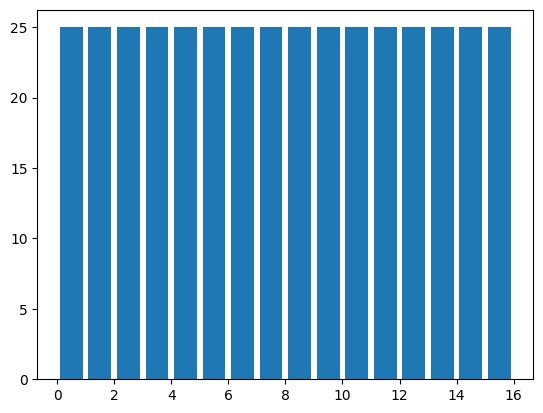

In [337]:
#próbki treningowe
plt.hist(data_train.class_no, bins = list(range(0, 17)), rwidth = 0.8)

(array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16.]),
 <BarContainer object of 16 artists>)

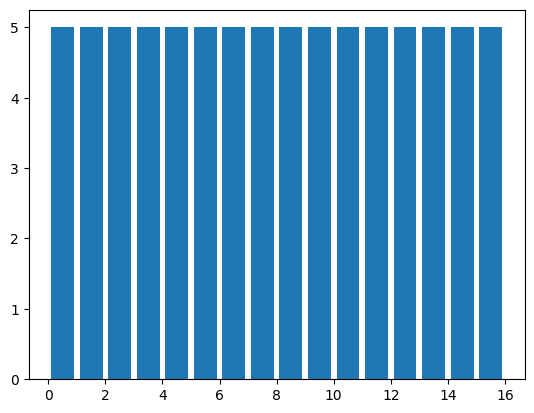

In [338]:
#próbki testowe
plt.hist(data_test.class_no, bins = list(range(0, 17)), rwidth = 0.8)

#### BoW + TF-IDF

In [339]:
data_test_bow = df_test
data_train_bow = df_train

In [340]:
data_test_bow['post_joined'] = data_test_bow.apply(lambda x: " ".join(x.post_cleaned), axis=1)
data_train_bow['post_joined'] = data_train_bow.apply(lambda x: " ".join(x.post_cleaned), axis=1)

In [341]:
#Bag of Words

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()  #jeśli max_features niezdefiniowane - cały słownik
X_bow = vectorizer.fit_transform(data_train_bow.post_joined)   #fit & transform
X_bow.shape  #400 postów, ponad 20 000 słów

(400, 21241)

In [342]:
#TF-IDF

from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_bow)
X_tfidf.shape  #ponad 400 postów, około 20 000 słów

(400, 21241)

In [343]:
# import tensorflow.keras.utils as ku
Y = data_train_bow.class_no

Regresja logistyczna

In [344]:
from sklearn.linear_model import LogisticRegression
model_log=LogisticRegression(max_iter=3000,C=0.5,n_jobs=-1)
model_log.fit(X_tfidf, Y)

LogisticRegression(C=0.5, max_iter=3000, n_jobs=-1)

In [345]:
X_bow_test = vectorizer.transform(data_test_bow.post_joined)   #transform
X_tfidf_test = tfidf_transformer.transform(X_bow_test)         #transform
X_tfidf_test.shape  #80 postów, ponad 20 000 słów

(80, 21241)

In [346]:
Y_test = data_test_bow.class_no

In [347]:
from sklearn.metrics import accuracy_score

#zbiór testowy
preds = model_log.predict(X_tfidf_test)
accuracy_score(Y_test, preds)

0.325

In [348]:
#zbiór treningowy
preds = model_log.predict(X_tfidf)
accuracy_score(Y, preds)

0.975

Liniowy klasyfikator SVM

In [349]:
from sklearn.svm import LinearSVC

model_linear_svc=LinearSVC(C=0.1)
model_linear_svc.fit(X_tfidf, Y)

c:\Users\marta\anaconda3\envs\mgr\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC(C=0.1)

In [350]:
from sklearn.metrics import accuracy_score

preds = model_linear_svc.predict(X_tfidf_test)
accuracy_score(Y_test, preds)

0.3625

In [351]:
#zbiór treningowy
preds = model_linear_svc.predict(X_tfidf)
accuracy_score(Y, preds)

0.995

Bayes

In [352]:
from sklearn.naive_bayes import MultinomialNB
model_bayes = MultinomialNB().fit(X_tfidf, Y)

In [353]:
from keras.metrics import categorical_accuracy

preds_train = model_bayes.predict(X_tfidf)
print("Dokładność na zbiorze treningowym wynosi: ", ((preds_train == Y).sum())/Y.shape[0])

preds_test = model_bayes.predict(X_tfidf_test)
print("Dokładność na zbiorze testowym wynosi: ", (preds_test == Y_test).sum()/Y_test.shape[0])

Dokładność na zbiorze treningowym wynosi:  0.9925
Dokładność na zbiorze testowym wynosi:  0.2625
